<a href="https://colab.research.google.com/github/talha1503/Language-Identification/blob/master/character_level_lstm_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
from csv import DictWriter
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
csv_path = '/content/drive/MyDrive/lid_dataset.csv'
dataset = pd.read_csv(csv_path)
dataset.columns = ['text','language']
dataset.head(10)

,text,language
0,winter storm taking aim at southeast,en_UK
1,toure ready to show credentials yaya toure bel...,en_UK
2,cnn fact check paying for that sputnik moment,en_UK
3,the taliban in pakistan weve got a bigger prob...,en_UK
4,bbc reporter people in cornwall make compariso...,en_UK
5,have a look here this should be useful,en_UK
6,hundreds die in cambodia stampede,en_UK
7,any luck chris let us know if you need any help,en_UK
8,o2 gets better connected on carbon,en_UK
9,coyle compiles referee dvd bolton manager owen...,en_UK


In [ ]:
lang_mapping = {
'de_DE':'German',
'en_UK':'English',
'es_ES':'Spanish',
'fr_FR':'French',
'it_IT':'Italian',
'nl_NL':'Dutch' 
}

dataset = dataset.replace({"language": lang_mapping},inplace=False)

In [ ]:
dataset['language'].value_counts()

Italian    7695
French     7583
English    7524
Spanish    2595
German     1479
Dutch      1430
Name: language, dtype: int64

In [ ]:
train_df_list = []
test_df_list = []
languages = dataset['language'].unique()
for language in languages:
  train_df_list.append(dataset[dataset['language'] == language][:1200])
  test_df_list.append(dataset[dataset['language'] == language][1200:1400])

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

print("Training dataset size: ",len(train_df))
print("Testing dataset size: ",len(test_df))

Training dataset size:  7200
Testing dataset size:  1200


In [ ]:
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df['language'].value_counts())
print(test_df['language'].value_counts())

German     1200
Italian    1200
French     1200
Dutch      1200
English    1200
Spanish    1200
Name: language, dtype: int64
English    200
French     200
German     200
Italian    200
Dutch      200
Spanish    200
Name: language, dtype: int64


In [ ]:
train_df.head()

,text,language
0,esther vergeer wint australian open 147ste toe...,Dutch
1,avec legypte lesprit les etatsunis accusent li...,French
2,a me funziona correttamente forse risulta solo...,Italian
3,zarate vs marchisio chi sar linseguitore più a...,Italian
4,sorry is it working again for you now,English


Mean character length: 80.06486111111111


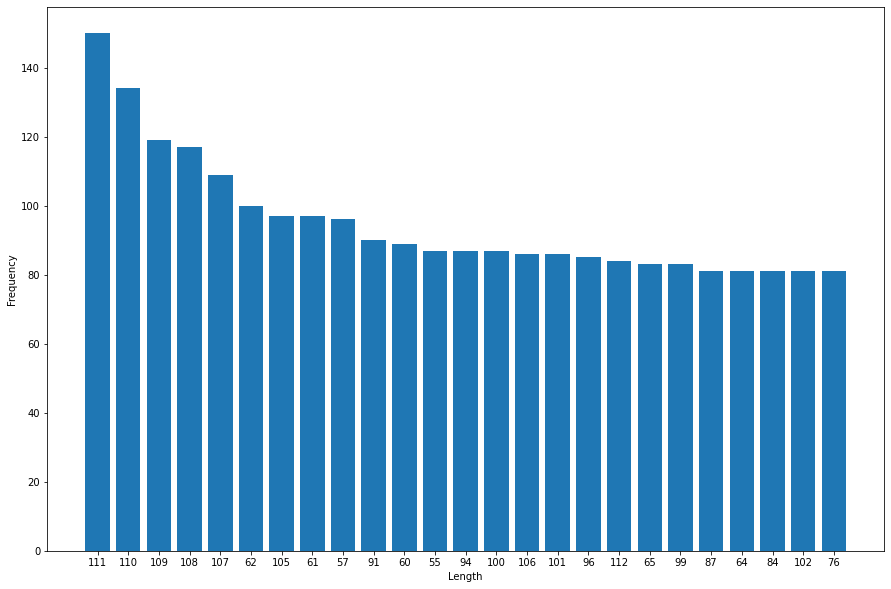

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
# Plotting character length frequencies
def get_length_dict(values):
  '''
  Returns a dictionary denoting frequency of values in the iterable.
  Input:
  values - Iterable
  Output:
  length_dict: dictionary
  '''
  mean_length = 0
  length_dict = {}
  for v in values:
      str_length = len(v)
      if length_dict.get(str_length):
          length_dict[str_length] += 1
      else:
          length_dict[str_length] = 1
      mean_length += str_length 
  mean_length /= len(values)

  print("Mean character length: {}".format(mean_length))
  length_dict = {k: v for k, v in sorted(length_dict.items(),reverse=True,key=lambda item: item[1])[:25]}
  return length_dict

length_dict = get_length_dict(train_df['text'].values)
plt.bar(range(len(length_dict)), list(length_dict.values()), align='center')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xticks(range(len(length_dict)), list(length_dict.keys()))
plt.show()

In [ ]:
MAX_LEN = 90

In [ ]:
classes = list(train_df['language'].unique())
class_mapping = {classes[i]:i for i in range(len(classes))}
reverse_class_mapping = {i:class_ for class_,i in class_mapping.items()}

print(class_mapping)
print(reverse_class_mapping)

{'Dutch': 0, 'French': 1, 'Italian': 2, 'English': 3, 'Spanish': 4, 'German': 5}
{0: 'Dutch', 1: 'French', 2: 'Italian', 3: 'English', 4: 'Spanish', 5: 'German'}


In [ ]:
def create_w2i_dict(df,column):
  '''
  Creates a word/character to index dictionary.
  Input:
  df- dataframe
  column- column to be selected from the dataframe.
  Output:
  word_to_indeX_dict: Dictionary containing word to ids mapping.
  '''
  word_to_index_dict = {}
  word_to_index_dict['<PAD>'] = 0
  word_to_index_dict['<UNK>'] = 1
  index = 1
  for text in df[column].values:
    for word in text:
      if not word_to_index_dict.get(word):
        word_to_index_dict[word] = index
        index += 1
  return word_to_index_dict

word_to_index_dict = create_w2i_dict(train_df,'text')
print("Total characters in vocab: ",len(word_to_index_dict.keys()))

Total characters in vocab:  61


In [ ]:
def string_to_tensor(string_inp,word_to_index_dict):
  '''
  Creates a tensor for an input string.
  Input:
  string_inp- String
  word_to_index_dict: 
  Output:
  string_tensor: Tensor containing representation of string with respect to word_to_index_dict 
  '''
  string_ids = []
  for char in string_inp:
    if word_to_index_dict.get(char):
      string_ids.append(word_to_index_dict[char])
    else:
      string_ids.append(word_to_index_dict['<UNK>'])
  
  if len(string_ids) > MAX_LEN:
    string_ids = string_ids[:MAX_LEN]
  else:
    string_ids.extend([0]*(MAX_LEN-len(string_ids)))

  string_tensor = torch.tensor(string_ids, device=device, dtype=torch.long)
  return string_tensor

In [ ]:
# Defining the hyperparameters of the model
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 200
VOCABULARY_SIZE = len(word_to_index_dict.keys())
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 4
K_FOLDS = 5
EPOCHS = 40
LEARNING_RATE = 1e-3
CRITERION = nn.CrossEntropyLoss()

In [ ]:
# Defining dataset class for our dataloader.
class LIDDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,class_mapping,word_to_index_dict):
    self.dataset = dataset  
    self.class_mapping = class_mapping
    self.w2i_dict = word_to_index_dict

  def __getitem__(self,index):
    x,y = self.dataset['text'][index],self.dataset['language'][index]
    x = string_to_tensor(x,self.w2i_dict)
    y = torch.tensor(self.class_mapping[y], device=device, dtype=torch.long)
    return x,y
  
  def __len__(self):
    return len(self.dataset)

In [ ]:
# Defining the lstm model 
class LSTMBaseline(nn.Module):
  def __init__(self,hidden_size,embedding_size,vocabulary_size):
    super().__init__()
    self.hidden_size = hidden_size 

    self.embedding_layer = nn.Embedding(vocabulary_size,embedding_size,padding_idx=0)
    self.lstm_layer = nn.LSTM(embedding_size,hidden_size,batch_first = True,bidirectional=True)        
    self.output_layer_1 = nn.Linear(hidden_size,100)
    self.output_layer_2 = nn.Linear(100,6)

  def forward(self,input_text):
    embeddings = self.embedding_layer(input_text)
    lstm_output,(hidden_state,cell_state) = self.lstm_layer(embeddings)
    linear_output_1 = F.relu(self.output_layer_1(hidden_state[-1,:,:].squeeze(0)))
    linear_output_2 = self.output_layer_2(linear_output_1)
    return linear_output_2

In [ ]:
def calculate_accuracy(model_outputs,targets):
  '''
  Function to calculate accuracy given model outputs (logits) and targets
  '''
  softmax_output = F.softmax(model_outputs,dim=-1)
  output_preds = torch.argmax(softmax_output,dim=-1)
  correct_results_sum = (output_preds == targets).sum().float()
  return correct_results_sum

In [ ]:
def train(criterion,epochs,dataset,k_folds,embedding_size,vocabulary_size,hidden_size,train_batch_size,valid_batch_size,learning_rate):
  kfold = KFold(n_splits=k_folds, shuffle=True)
  fold_values = 0
  average_validation_loss = []
  average_accuracy = []
  metric_dict = {}
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    metric_dict[fold] = {
        'training_loss':[],
        'training_accuracy':[],
        'validation_accuracy':[],
        'validation_loss':[]
    }
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trainloader = torch.utils.data.DataLoader(
                  dataset, 
                  batch_size=train_batch_size, sampler=train_subsampler,drop_last=True)
    validloader = torch.utils.data.DataLoader(
                  dataset,
                  batch_size=valid_batch_size, sampler=test_subsampler,drop_last=True)
    
    model = LSTMBaseline(hidden_size,embedding_size,vocabulary_size)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_accuracy = 0
        for i, data in enumerate(trainloader, 0):
            model.train()
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs= model(inputs)
            loss = criterion(outputs,targets)
            epoch_loss += loss.item()
            epoch_accuracy += calculate_accuracy(outputs,targets)

            loss.backward()
            optimizer.step()
        

        epoch_accuracy = (epoch_accuracy/(len(trainloader)*train_batch_size))*100
        epoch_loss = (epoch_loss/(i+1))
        metric_dict[fold]['training_loss'].append(epoch_loss)
        metric_dict[fold]['training_accuracy'].append(epoch_accuracy)
        if epoch % 10 == 0:
            # epoch_loss = (epoch_loss/(i+1))
            print("Epoch: {} Training Loss: {} Training Accuracy: {}".format(epoch,epoch_loss,epoch_accuracy))

        with torch.no_grad():
            current_test_loss = 0
            epoch_test_loss = 0
            epoch_test_accuracy = 0
            for i, data in enumerate(validloader, 0):
                model.eval()
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                loss = criterion(outputs,targets)
                epoch_test_loss += loss.item()
                epoch_test_accuracy += calculate_accuracy(outputs,targets)
        
            epoch_test_accuracy = (epoch_test_accuracy / (len(validloader)*valid_batch_size))*100
            epoch_test_loss = (epoch_test_loss/(i+1))
            metric_dict[fold]['validation_loss'].append(epoch_test_loss)
            metric_dict[fold]['validation_accuracy'].append(epoch_test_accuracy)
            if epoch % 10 == 0:
              print("Epoch: {} Validation Loss: {} Validation Accuracy: {}".format(epoch,epoch_test_loss,epoch_test_accuracy))
        
    average_validation_loss.append(epoch_test_loss)
    average_accuracy.append(epoch_test_accuracy)

    torch.save(model,'/content/drive/MyDrive/LIDModels/char_lstm_baseline_{}.pkl'.format(fold))
    print('--------------------------------')
    
  print(f'Average Validation Loss:{sum(average_validation_loss)/len(average_validation_loss)}')
  print('Average accuracy: {}'.format(sum(average_accuracy)/len(average_accuracy)))
  return metric_dict

In [ ]:
train_dataset = LIDDataset(train_df,class_mapping,word_to_index_dict)
metrics = train(CRITERION,EPOCHS,train_dataset,K_FOLDS,EMBEDDING_SIZE,
      VOCABULARY_SIZE,HIDDEN_SIZE,TRAIN_BATCH_SIZE,VALID_BATCH_SIZE,LEARNING_RATE)

FOLD 0
--------------------------------
Epoch: 0 Training Loss: 0.966472698872288 Training Accuracy: 63.05555725097656
Epoch: 0 Validation Loss: 0.3872918558306992 Validation Accuracy: 87.15277862548828
Epoch: 10 Training Loss: 0.03287686443806403 Training Accuracy: 98.90625762939453
Epoch: 10 Validation Loss: 0.18085901409486982 Validation Accuracy: 95.27777862548828
Epoch: 20 Training Loss: 0.01916279142717738 Training Accuracy: 99.30555725097656
Epoch: 20 Validation Loss: 0.1896229557229775 Validation Accuracy: 95.97222137451172
Epoch: 30 Training Loss: 0.014729940161032573 Training Accuracy: 99.72222137451172
Epoch: 30 Validation Loss: 0.19422330476497468 Validation Accuracy: 96.45833587646484
--------------------------------
FOLD 1
--------------------------------
Epoch: 0 Training Loss: 1.079949838668108 Training Accuracy: 58.00347137451172
Epoch: 0 Validation Loss: 0.47871206366560526 Validation Accuracy: 83.47222137451172
Epoch: 10 Training Loss: 0.028074120591392988 Training A

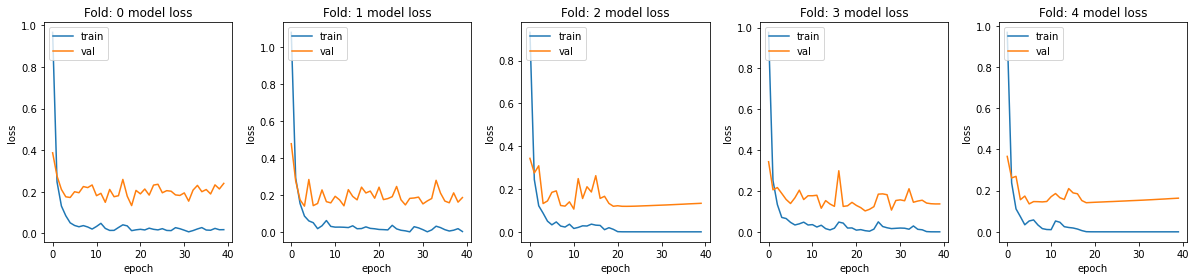

In [ ]:
plt.figure(figsize=(20, 4))

for i in range(len(metrics.keys())):
  plt.subplot(1,len(metrics.keys())+1,i+1)
  plt.plot(metrics[i]['training_loss'])
  plt.plot(metrics[i]['validation_loss'])
  plt.title('Fold: {} model loss'.format(i))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

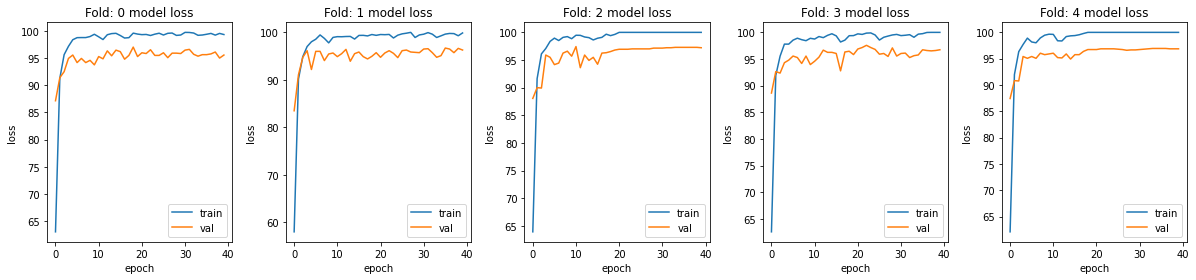

In [ ]:
plt.figure(figsize=(20, 4))

for i in range(len(metrics.keys())):
  plt.subplot(1,len(metrics.keys())+1,i+1)
  plt.plot(metrics[i]['training_accuracy'])
  plt.plot(metrics[i]['validation_accuracy'])
  plt.title('Fold: {} model loss'.format(i))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
def test(testdataset):
  testloader = torch.utils.data.DataLoader(testdataset, batch_size=1,drop_last=True)
  with torch.no_grad():
    model = torch.load('/content/drive/MyDrive/LIDModels/char_lstm_baseline_2.pkl')      
    epoch_test_accuracy = 0
    for i, data in enumerate(testloader, 0):
        model.eval()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        epoch_test_accuracy += calculate_accuracy(outputs,targets)

    epoch_test_accuracy = (epoch_test_accuracy/ len(testloader)) * 100
    print("Accuracy: {} ".format(epoch_test_accuracy))

test_dataset = LIDDataset(test_df,class_mapping,word_to_index_dict)
test(test_dataset)

Accuracy: 96.41667175292969 


In [ ]:
import pickle
pickle.dump(word_to_index_dict,open('/content/drive/MyDrive/LIDModels/char_word_to_index_dict.pkl','wb'))
pickle.dump(class_mapping,open('/content/drive/MyDrive/LIDModels/char_class_mapping.pkl','wb'))
pickle.dump(reverse_class_mapping,open('/content/drive/MyDrive/LIDModels/char_reverse_class_mapping.pkl','wb'))

In [ ]:
def test_one_sample(text):
  word_to_index_dict = pickle.load(open('/content/drive/MyDrive/LIDModels/char_word_to_index_dict.pkl','rb'))
  class_mapping = pickle.load(open('/content/drive/MyDrive/LIDModels/char_reverse_class_mapping.pkl','rb'))
  char_tensor = string_to_tensor(text,word_to_index_dict) 
  with torch.no_grad():
    model = torch.load('/content/drive/MyDrive/LIDModels/char_lstm_baseline_2.pkl')      
    # model = torch.load('./lstm_baseline_2.pkl')      
    model.eval()
    outputs = model(char_tensor.unsqueeze(0))
    softmax_output = F.softmax(outputs,dim=-1)
    output_preds = torch.argmax(softmax_output,dim=-1)
    # print("Given text: ",text)
    # print("Predicted language: {}".format(class_mapping[output_preds.item()]))
    return class_mapping[output_preds.item()]

In [ ]:
lang_labels = sklearn.utils.multiclass.unique_labels(test_df['language'].values)
print(lang_labels)

['Dutch' 'English' 'French' 'German' 'Italian' 'Spanish']


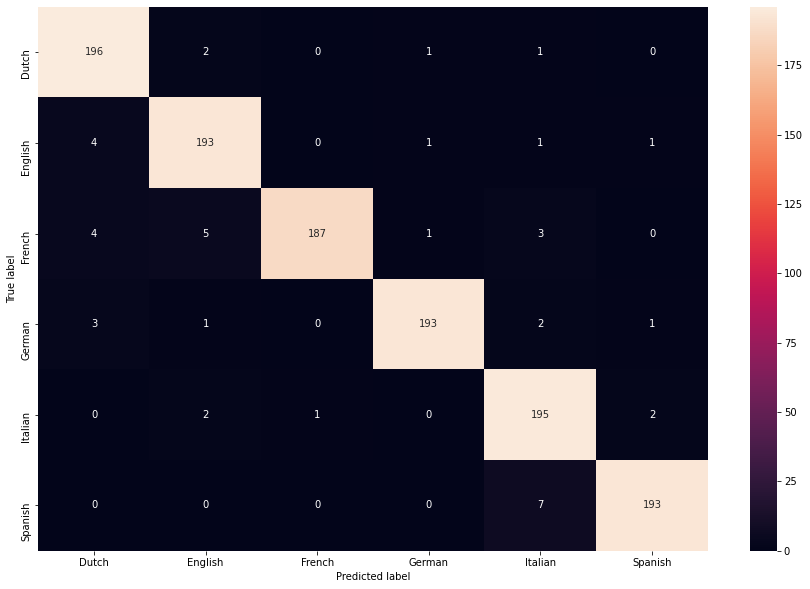

In [ ]:
def get_preds(df):
  dataset_preds = []
  for index,row in df.iterrows():
    dataset_preds.append(test_one_sample(row['text']))
  return dataset_preds

dataset_preds = get_preds(test_df)
cm = confusion_matrix(test_df['language'].values, dataset_preds)
cm_df = pd.DataFrame(cm,index = list(lang_labels), 
                     columns = list(lang_labels))

plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
clf_report = classification_report(test_df['language'].values, dataset_preds)
print(clf_report)

              precision    recall  f1-score   support

       Dutch       0.95      0.98      0.96       200
     English       0.95      0.96      0.96       200
      French       0.99      0.94      0.96       200
      German       0.98      0.96      0.97       200
     Italian       0.93      0.97      0.95       200
     Spanish       0.98      0.96      0.97       200

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



In [ ]:
test_one_sample("what's up")

'English'